# Методы Оптимизации
## Задача классификации изображений
### Студент: Ярослав Спирин (группа 594)

In [41]:
import numpy as np # vectorized math
import scipy.misc # image loading
import os # to get all images from the directory
from tqdm import tqdm_notebook as tqdm # tracking loop progress
import matplotlib.pyplot as plt # to show plots and images
import matplotlib
from scipy.ndimage import uniform_filter
from matplotlib.mlab import PCA # PCA encoder
import pandas as pd # working with dataframes

Поскольку будем использовать генератор случайных чисел, нужно фиксировать seed.

In [42]:
np.random.seed(42)

Для начала загрузим данные и представим каждую картинку в виде вектора признаков следующим образом:
![](https://cdn-images-1.medium.com/max/1600/1*Vo8PMHppg_lWxFAZHZzNGQ.png)

Поскольку картинки имеют разрешение 32x32 и каждый пиксель отвечает за наполнение 3-мя цветами, у нас получится, что каждая картинка - это элемент пространства размерности 3072. В дальнейшем мы будем использовать метод уменьшения размерности PCA, поскольку данные из пространства размерности 3072, описывающие пиксели картинки - избыточны.

** Update: ** Таким было бы решение, если бы не было необходимости занимать верхние места в Kaggle Leaderboard (https://www.kaggle.com/c/fivt-metopt-2017/leaderboard). Чтобы достичь лучших результатов, я предлагаю подход использующий не пиксели в качестве фичей, а более информативные свойства, которыми обладает каждая картинка из датасета. Например, цветовые гистограммы, гистограмма ориентированных градиентов и другие.

Некоторые подходы заимствованы из курса cs231n Stanford University.

In [43]:
# Возвращает цветовые гистограммы
def color_histogram_hsv(im, nbin=10, xmin=0, xmax=255, normalized=True):
    ndim = im.ndim
    bins = np.linspace(xmin, xmax, nbin+1)
    hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax
    imhist, bin_edges = np.histogram(hsv[:,:,0], bins=bins, density=normalized)
    imhist = imhist * np.diff(bin_edges)

    # return histogram
    return imhist

# Перевести картинку из формата RGB в черно-белый
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

# Извлечь гистограмму ориентрованных градиентов
# https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
def hog_feature(im):
    
    # convert rgb to grayscale if needed
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.at_least_2d(im)

    sx, sy = image.shape # image size
    orientations = 9 # number of gradient bins
    cx, cy = (8, 8) # pixels per cell

    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)
    gx[:, :-1] = np.diff(image, n=1, axis=1) # compute gradient on x-direction
    gy[:-1, :] = np.diff(image, n=1, axis=0) # compute gradient on y-direction
    grad_mag = np.sqrt(gx ** 2 + gy ** 2) # gradient magnitude
    grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90 # gradient orientation

    n_cellsx = int(np.floor(sx / cx))  # number of cells in x
    n_cellsy = int(np.floor(sy / cy))  # number of cells in y
    # compute orientations integral images
    orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))
    for i in range(orientations):
        # create new integral image for this orientation
        # isolate orientations in this range
        temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                        grad_ori, 0)
        temp_ori = np.where(grad_ori >= 180 / orientations * i,
                        temp_ori, 0)
        # select magnitudes for those orientations
        cond2 = temp_ori > 0
        temp_mag = np.where(cond2, grad_mag, 0)
        orientation_histogram[:,:,i] = uniform_filter(temp_mag, size=(cx, cy))[int(cx/2)::cx, int(cy/2)::cy].T
  
    return orientation_histogram.ravel()

In [44]:
# Функция извлечения фичей
def extract_features(sample):
    # hsv
    hsv = color_histogram_hsv(sample, nbin=80)
    
    # hog
    hog = hog_feature(sample)
    
    # color hist
    sample = sample.reshape(sample.shape[0] * sample.shape[1], -1)
    
    red_buckets, _ = np.histogram(sample[:, 0], bins=range(0, 256, 3))
    green_buckets, _ = np.histogram(sample[:, 1], bins=range(0, 256, 3))
    blue_buckets, _ = np.histogram(sample[:, 2], bins=range(0, 256, 3))
    
    # volume color hist
    volume_color_hist, _ = np.histogramdd(sample, bins=[8, 8, 8])
    volume_color_buckets = volume_color_hist.flatten()
    
    features = np.concatenate((red_buckets, green_buckets, blue_buckets, volume_color_buckets, hog, hsv))
    
    return features

In [45]:
# Функция загружающая картинки из соотвествующих директорий
def load_images():
    X_train = []
    y_train = []
    flatten_train_images = []
    
    for filename in tqdm(os.listdir("train"), desc="train loop"):
        train_image = scipy.misc.imread("train/{}".format(filename), mode="RGB")
        flipped_train_image = np.flip(train_image, axis=1)
        
        X_train.append(extract_features(train_image))
        flatten_train_images.append(train_image.flatten())
        
        X_train.append(extract_features(flipped_train_image))
        flatten_train_images.append(flipped_train_image.flatten())
        
        if filename.startswith("indoor"):
            y_train.append(1)
            y_train.append(1)
        else:
            y_train.append(0)
            y_train.append(0)
    
    X_test = [] 
    flatten_test_images = []
    
    for filename in tqdm(os.listdir("test"), desc="test loop"):
        test_image = scipy.misc.imread("test/{}".format(filename), mode="RGB")
        
        X_test.append(extract_features(test_image))
        flatten_test_images.append(test_image.flatten())
        
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    
    # adding pixels features
    flatten_train_images = np.array(flatten_train_images)
    flatten_test_images = np.array(flatten_test_images)

    num_train = flatten_train_images.shape[0]
    num_test = flatten_test_images.shape[0]
    
    pca_matrix = PCA(np.vstack((flatten_train_images, flatten_test_images)))
    pca_matrix = pca_matrix.Y[:, :200]
    
    img_feature_train = pca_matrix[:num_train]
    img_feature_test = pca_matrix[num_train:]
    
    X_train = np.hstack((X_train, img_feature_train))
    X_test = np.hstack((X_test, img_feature_test))
    
    return X_train, y_train, X_test

In [46]:
X, y, X_test = load_images()

Далее отнормируем фичи по формуле: $$ X = \frac {X}  {X_{max}} $$, как показала практика такая нормировка оказалась даже лучше общепринятого нормирования $$ X = \frac {X - X_{min}} {X_{max} - X_{min}}$$ и $$ X = \frac {X - X_{mean}} {std(X)} $$ После такого преобразования градиентный спуск будет сходится быстрее. (https://en.wikipedia.org/wiki/Feature_scaling)

In [47]:
def normalize_batch(X):
    return X / X.max()

In [48]:
def normalize(X, partitions):
    aux = np.hstack((np.array([0]), partitions))
    cumsum = np.cumsum(aux)
    for i in range(1, len(cumsum)):
        X[:, cumsum[i - 1]:cumsum[i]] = normalize_batch(X[:, cumsum[i - 1]:cumsum[i]])
        
    return X

In [49]:
color_bucket_size = len(range(0, 256, 3))
volume_buckets_size = 8 * 8 * 8
hog_size = 144
hsv_size = 80
pixels_size = 200

partitions = [color_bucket_size,
              color_bucket_size,
              color_bucket_size,
              volume_buckets_size,
              hog_size,
              hsv_size,
              pixels_size
             ]

num_train = X.shape[0]

normalized_data = normalize(np.vstack((X, X_test)), partitions)

X = normalized_data[:num_train]
X_test = normalized_data[num_train:]

Разделим выборку `X` на `X_train` и `X_val` для того, чтобы проверять точность модели. При этом разделение будем производить случайным образом, чтобы исключить дальнейшее возникновение переобучения.

In [50]:
def train_and_val(X, y, ratio=0.75):
    # samples with odd indices are flipped images - can't use them in validation
    
    # 1. split into odd and even rows
    X_even = X[::2]
    X_odd = X[1::2]
    
    y_even = y[::2]
    y_odd = y[1::2]
    
    # 2. subsampling from even rows
    indices = np.arange(len(X_even))
    np.random.shuffle(indices)
    
    num_train = int(ratio * len(X_even))
    
    X_train = X_even[indices[:num_train]]
    X_val = X_even[indices[num_train:]]
    
    y_train = y_even[indices[:num_train]]
    y_val = y_even[indices[num_train:]]
    
    # 3. subsampling from odd rows
    indices = np.arange(len(X_odd))
    np.random.shuffle(indices)
    
    X_train = np.vstack((X_train, X_odd[indices]))
    y_train = np.hstack((y_train, y_odd[indices]))
    
    return X_train, y_train, X_val, y_val

In [51]:
X_train, y_train, X_val, y_val = train_and_val(X, y)

In [52]:
X_train = X_train.astype("float64")
X_val = X_val.astype("float64")

Изобразим на гистограмме как выглядит один вектор признаков для картинки.

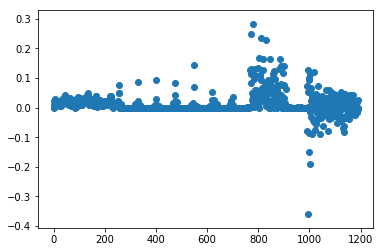

In [53]:
plt.scatter(np.arange(X_train[1300].shape[0]), X_train[1300])
plt.show()

Поскольку логистическая регрессия использует линейную модель $y = XW + b$, добавим дополнительный столбец (соответствующий $b$) к `X_train` и `X_test`. Таким образом, мы сделаем работу нашего алгоритма более прямолинейной. Как итог получим модель, которая выглядит более приятно: $y = XW$

In [54]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

Теперь реализуем класс линейного классификатора, основываясь на лекции курса cs231n (Stanford University).

Реализация использует аналитически посчитанный градиент для большей точности.

$$ scores = XW $$ и $$ softmax = \frac { e^{scores_{correctclass}} } {\sum{e^{scores_{class}}}} $$

Функцию потерь определим так: $$ Loss = \frac {1} {N} \sum{Loss_i} + \lambda \sum\sum{W_{i,j}^2} $$, где $$ Loss_i = -\log(\frac { e^{scores_{correctclass}} } {\sum{e^{scores_{class}}}}) $$

Кроме того, классификатор позволяет считать функцию потерь на валидационной выборке и позволяет настраивать шаг градиентного спуска `learning_rate` и регуляризацию `reg`.

In [55]:
class SoftmaxClassifier:

    ### Initialize classifier
    def __init__(self):
        self.W = None

    ### Train the logistic regression model using Gradient Descent algorithm
    def train(self, X, y, X_val=None, y_val=None, learning_rate=1e-3, reg=1e-5, num_iters=100, verbose=False):
        num_train, dim = X.shape
        num_classes = np.max(y) + 1
        
        if self.W is None:
            self.W = 0.0001 * np.random.randn(dim, num_classes)

        # Run gradient descent to optimize W
        loss_history = []
        loss_val_history = []
        for it in range(num_iters):
            # evaluate loss and gradient
            loss, grad, loss_val = self.softmax_loss_vectorized(X, y, reg, X_val, y_val)
            
            #loss_history.append(loss)
            #loss_val_history.append(loss_val)
            
            # update parameters
            self.W += -learning_rate * grad

            if verbose and it % 100 == 0:
                
                if len(loss_val_history) > 0 and loss_val_history[-1] < loss_val:
                    break
                
                loss_history.append(loss)
                loss_val_history.append(loss_val)
                
                print('iteration %d / %d: loss %f; validation loss %f' % (it, num_iters, loss, loss_val))
                

        return loss_history
    
    ### Predict the output value for the test sample
    def predict(self, X):
        scores = np.dot(X, self.W)
        max_scores = np.max(scores, axis=1).reshape(scores.shape[0], -1)
        scores -= max_scores
        probs = np.exp(scores) / np.sum(np.exp(scores), axis=1).reshape(scores.shape[0], -1)
        return probs[:, 1]
        
    ### Calculate the loss and gradient
    def softmax_loss_vectorized(self, X, y, reg, X_val, y_val):
  
        # Initialize the loss and gradient to zero
        loss = 0.0
        loss_val = 0.0
        dW = np.zeros_like(self.W)
  
        num_train = X.shape[0]
        num_classes = self.W.shape[1]

        # Loss calculation
        scores = np.dot(X, self.W)
        max_scores = np.max(scores, axis=1).reshape(scores.shape[0], -1)
        scores -= max_scores
        
        arange = np.arange(0, num_train)
    
        correct_class_scores = scores[arange, y]
        logistic_function = np.exp(correct_class_scores) / np.sum(np.exp(scores), axis=1)
        loss += -np.sum(np.log(logistic_function))
    
        loss /= num_train
        loss += reg * np.sum(self.W * self.W)
   

        # Gradient calculation
        aux = np.exp(scores) / np.sum(np.exp(scores), axis=1).reshape(scores.shape[0], -1)
        dW += np.dot(X.T, aux)
    
        correct_classes = np.zeros(scores.shape)
        correct_classes[arange, y] = 1
        dW -= np.dot(X.T, correct_classes)
    
        dW /= num_train
        dW += 2 * reg * self.W
        
        # Validation loss calculation
        num_train = X_val.shape[0]
        
        scores = np.dot(X_val, self.W)
        max_scores = np.max(scores, axis=1).reshape(scores.shape[0], -1)
        scores -= max_scores
        
        arange = np.arange(0, num_train)
    
        correct_class_scores = scores[arange, y_val]
        logistic_function = np.exp(correct_class_scores) / np.sum(np.exp(scores), axis=1)
        loss_val += -np.sum(np.log(logistic_function))
    
        loss_val /= num_train
        loss_val += reg * np.sum(self.W * self.W)
        
        return loss, dW, loss_val

## Bootstrapping
Данный подход подразумевает то, что мы настраиваем несколько моделей на случайных подвыборках исходного датасета, а затем усредним показатели на тестовой выборке.

In [56]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [57]:
data_splits = [list(train_and_val(X, y)) for i in range(5)]
classifiers = []


for i in range(5):
    print("Softmax Classifier {}".format(i + 1))
    
    data_splits[i][0] = data_splits[i][0].astype("float64")
    data_splits[i][2] = data_splits[i][2].astype("float64")
    
    data_splits[i][0] = np.hstack([data_splits[i][0], np.ones((data_splits[i][0].shape[0], 1))])
    data_splits[i][2] = np.hstack([data_splits[i][2], np.ones((data_splits[i][2].shape[0], 1))])
    
    softmax = SoftmaxClassifier()
    softmax.train(data_splits[i][0], data_splits[i][1],
                  data_splits[i][2], data_splits[i][3],
                  learning_rate=12, reg=0,
                  num_iters=3000, verbose=True)
    
    classifiers.append(softmax)
    print()

Softmax Classifier 1
iteration 0 / 3000: loss 0.693109; validation loss 0.693115
iteration 100 / 3000: loss 0.177259; validation loss 0.184047
iteration 200 / 3000: loss 0.162791; validation loss 0.173344
iteration 300 / 3000: loss 0.154399; validation loss 0.167811
iteration 400 / 3000: loss 0.148668; validation loss 0.164381
iteration 500 / 3000: loss 0.144407; validation loss 0.162076
iteration 600 / 3000: loss 0.141058; validation loss 0.160447
iteration 700 / 3000: loss 0.138322; validation loss 0.159256
iteration 800 / 3000: loss 0.136021; validation loss 0.158364
iteration 900 / 3000: loss 0.134044; validation loss 0.157683
iteration 1000 / 3000: loss 0.132317; validation loss 0.157158
iteration 1100 / 3000: loss 0.130788; validation loss 0.156750
iteration 1200 / 3000: loss 0.129419; validation loss 0.156431
iteration 1300 / 3000: loss 0.128182; validation loss 0.156181
iteration 1400 / 3000: loss 0.127058; validation loss 0.155986
iteration 1500 / 3000: loss 0.126028; validati

In [58]:
### Predictions
predictions = []
scores = []

for i in range(5):
    y_test_pred = classifiers[i].predict(X_test)
    y_val_pred = classifiers[i].predict(data_splits[i][2])
    predictions.append(y_test_pred)
    scores.append(rmse(y_val_pred, data_splits[i][3]))
    
# predictions = np.array(predictions)
predictions = np.mean(predictions, axis=0)
print(scores)

[0.20823714938842042, 0.19764514905556788, 0.19173392207750345, 0.193521739564605, 0.19142561883711307]


In [59]:
data = []

for i, filename in enumerate(os.listdir("test")):
    data.append([int(filename[4:-4]), predictions[i]])

In [60]:
df = pd.DataFrame(data, columns=['id', 'res'])

In [61]:
df.head()

,id,res
0,329,0.999968
1,2818,0.002383
2,473,0.080105
3,1493,0.001379
4,315,0.978596


In [62]:
df.to_csv('submission.csv', columns=['id', 'res'], sep=',', index=False)